In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Convolution2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D,ZeroPadding2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
imggen = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1/255.0,validation_split=0.2)

batch_size=32
filepath = '/home/ubuntu/data/AFAD-Full/AFAD_age'
train_datagen_age = imggen.flow_from_directory(filepath, target_size=(100,100),batch_size=batch_size, 
                                           class_mode = 'sparse',subset='training')
validation_datagen_age = imggen.flow_from_directory(filepath, target_size=(100,100), batch_size=batch_size
                                                , class_mode = 'sparse', subset='validation')

Found 131541 images belonging to 26 classes.
Found 32877 images belonging to 26 classes.


In [3]:
age_model = Sequential()
age_model.add(Convolution2D(filters = 64, kernel_size = (3, 3), 
      padding = 'same',input_shape=(100,100,3), activation = 'relu'))
age_model.add(MaxPooling2D(pool_size= (2, 2)))
age_model.add(Convolution2D(filters = 32, kernel_size = (3, 3), 
                              padding = 'same', activation = 'relu'))
age_model.add(MaxPooling2D(pool_size= (2, 2)))
age_model.add(Dropout(0.5))
age_model.add(Flatten())
age_model.add(Dense(128, activation = 'relu'))
age_model.add(Dense(64, activation = 'relu'))
age_model.add(Dropout(0.5))
age_model.add(Dense(1, activation = 'linear'))

opt = keras.optimizers.Adam(learning_rate=0.0003)
age_model.compile(optimizer=opt, 
                  loss='mean_absolute_error', metrics=['mse'])

age_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 25, 25, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20000)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2

In [4]:
checkpoint = ModelCheckpoint('age_estimator.h5', monitor = 'val_loss', 
                             mode = 'min', save_best_only = True, verbose = 1)

earlystopping = EarlyStopping(monitor= 'val_loss', patience = 15, 
                              verbose = 1, restore_best_weights= True)

In [5]:
history_age = age_model.fit_generator(train_datagen_age, epochs=50, verbose=2,
                    validation_data=validation_datagen_age,callbacks=[earlystopping, checkpoint])

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 4111 steps, validate for 1028 steps
Epoch 1/50

Epoch 00001: val_loss improved from inf to 4.62368, saving model to age_estimator.h5
4111/4111 - 170s - loss: 5.0118 - mse: 42.4262 - val_loss: 4.6237 - val_mse: 34.4689
Epoch 2/50

Epoch 00002: val_loss improved from 4.62368 to 4.50239, saving model to age_estimator.h5
4111/4111 - 145s - loss: 4.7840 - mse: 38.9788 - val_loss: 4.5024 - val_mse: 33.4629
Epoch 3/50

Epoch 00003: val_loss did not improve from 4.50239
4111/4111 - 145s - loss: 4.6856 - mse: 37.5984 - val_loss: 4.5301 - val_mse: 32.5008
Epoch 4/50

Epoch 00004: val_loss did not improve from 4.50239
4111/4111 - 145s - loss: 4.6068 - mse: 36.5321 - val_loss: 4.5555 - val_mse: 31.9021
Epoch 5/50

Epoch 00005: val_loss improved from 4.50239 to 4.34969, saving model to age_estimator.h5
4111/4111 - 145s - loss: 4.5320 - mse: 35.4799 - val_loss: 4.34

In [6]:
def graph_MAE(history,title):
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.plot(history.history['loss'], label='Train')
    ax.plot(history.history['val_loss'], label='Test')
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Mean Absolute Error")
    ax.legend()

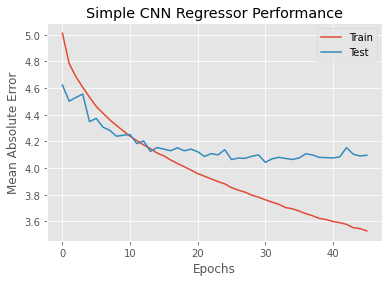

In [7]:
graph_MAE(history_age, 'Simple CNN Regressor Performance')

In [8]:
def y_true_generator(datagen):
    y = np.array([])
    
    for i in datagen:
        y = np.append(y, datagen[i][1])
            
    return y

In [10]:
y_true = np.array([])

for i in range(len(validation_datagen_age)):
    y_true = np.append(y_true, validation_datagen_age[i][1])

y_true.reshape(-1,1)

array([[14.],
       [ 9.],
       [10.],
       ...,
       [ 6.],
       [17.],
       [ 9.]])

In [13]:
X_test = np.array([])

for i in range(len(validation_datagen_age)):
    X_test = np.append(X_test, validation_datagen_age[i][0])

array([[-0.00222991],
       [-0.00127643],
       [-0.00336794],
       ...,
       [ 0.00275279],
       [ 0.00272203],
       [ 0.00266052]])

In [24]:
X_test = X_test.reshape(-1,100,100,3)

In [27]:
X_test[1].shape

(100, 100, 3)

In [28]:
y_pred = age_model.predict_classes(validation_datagen_age)

ValueError: The `batch_size` argument must not be specified for the given input type. Received input: <keras_preprocessing.image.directory_iterator.DirectoryIterator object at 0x7ff94fe17518>, batch_size: 32

In [30]:
import pickle
with open('history_age.pickle', 'wb') as f:
    pickle.dump(history_age.history, f)